# Customer Segmentation using RFM Analysis and K-Means Clustering

This project analyzes customer purchase behavior using RFM (Recency, Frequency, Monetary) analysis and K-Means clustering.  
We'll segment customers based on their transactional patterns to help businesses target the right groups for marketing campaigns.


In [4]:
# 📦 Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 📥 Load the dataset
df = pd.read_csv('../data/customer_shopping_data.csv')
df.columns = df.columns.str.strip().str.lower()  # sanitize column names
df.head()


,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,9/11/2021,Metrocity
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM
4,I337046,C189076,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon


In [5]:
# Convert invoice_date to datetime
df['invoice_date'] = pd.to_datetime(df['invoice_date'], errors='coerce')

# Drop rows with missing invoice_date
df = df.dropna(subset=['invoice_date'])

# ✅ Create total_amount column
df['total_amount'] = df['quantity'] * df['price']

# Check for nulls
df.isnull().sum()


invoice_no        0
customer_id       0
gender            0
age               0
category          0
quantity          0
price             0
payment_method    0
invoice_date      0
shopping_mall     0
total_amount      0
dtype: int64

In [6]:
# Set reference date for recency calculation
now = df['invoice_date'].max() + pd.Timedelta(days=1)

# Create RFM table
rfm = df.groupby('customer_id').agg({
    'invoice_date': lambda x: (now - x.max()).days,      # Recency
    'invoice_no': 'nunique',                             # Frequency
    'total_amount': 'sum'                                # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,C100005,275,1,2400.68
1,C100006,690,1,322.56
2,C100025,1002,1,143.36
3,C100034,908,1,1200.32
4,C100042,611,1,650.56


In [7]:
# Extract RFM features
rfm_features = rfm[['Recency', 'Frequency', 'Monetary']]

# Scale the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

# Convert back to DataFrame
rfm_normalized = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])
rfm_normalized.head()


,Recency,Frequency,Monetary
0,-1.485833,0.0,-0.030062
1,0.129742,0.0,-0.522871
2,1.344343,0.0,-0.565367
3,0.978405,0.0,-0.314717
4,-0.177801,0.0,-0.445088


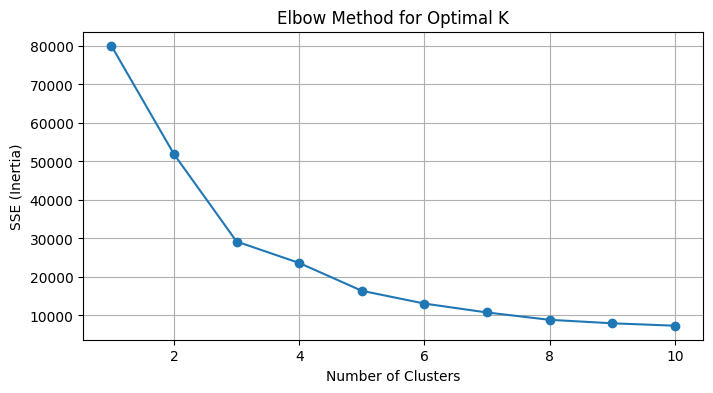

In [8]:
sse = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_normalized)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(k_range, sse, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE (Inertia)')
plt.grid(True)

# Save the elbow plot
plt.savefig('../images/elbow_plot.png', dpi=300, bbox_inches='tight')
plt.show()


In [9]:
# Choose optimal k from elbow plot (e.g., 4)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_normalized)

# Preview with cluster labels
rfm.head()


,CustomerID,Recency,Frequency,Monetary,Cluster
0,C100005,275,1,2400.68,1
1,C100006,690,1,322.56,3
2,C100025,1002,1,143.36,0
3,C100034,908,1,1200.32,0
4,C100042,611,1,650.56,3


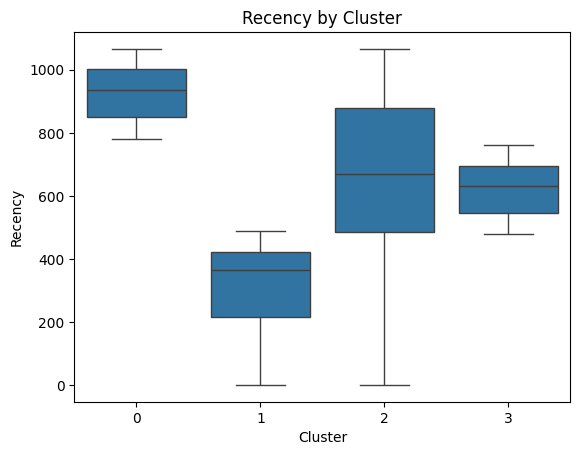

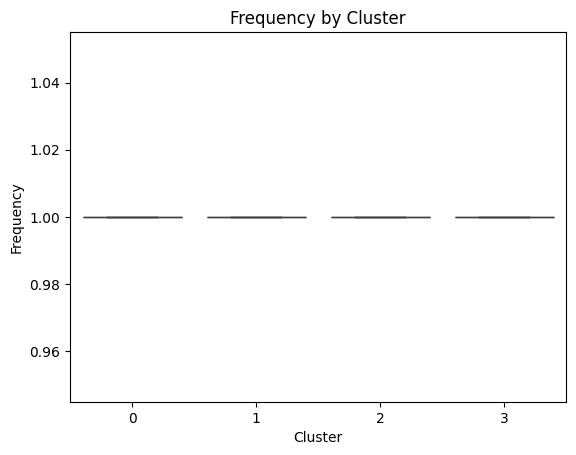

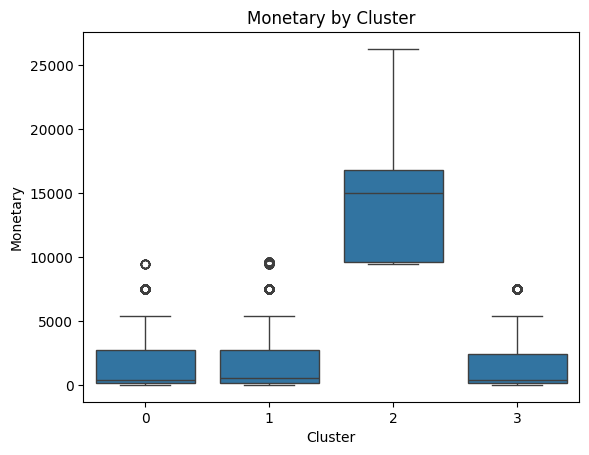

In [10]:
sns.boxplot(x='Cluster', y='Recency', data=rfm)
plt.title('Recency by Cluster')
plt.savefig('../images/recency_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

sns.boxplot(x='Cluster', y='Frequency', data=rfm)
plt.title('Frequency by Cluster')
plt.savefig('../images/frequency_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

sns.boxplot(x='Cluster', y='Monetary', data=rfm)
plt.title('Monetary by Cluster')
plt.savefig('../images/monetary_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()


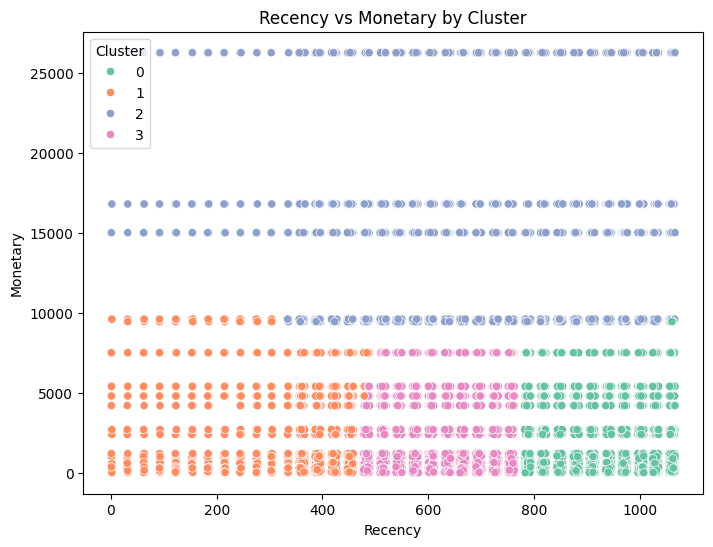

In [11]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='Recency', y='Monetary', hue='Cluster', data=rfm, palette='Set2')
plt.title('Recency vs Monetary by Cluster')
plt.savefig('../images/recency_vs_monetary.png', dpi=300, bbox_inches='tight')
plt.show()


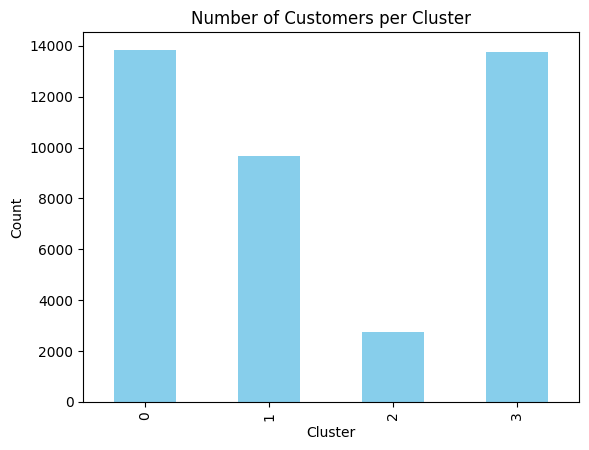

In [12]:
cluster_sizes = rfm['Cluster'].value_counts().sort_index()
cluster_sizes.plot(kind='bar', color='skyblue')
plt.title('Number of Customers per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.savefig('../images/cluster_sizes.png', dpi=300, bbox_inches='tight')
plt.show()


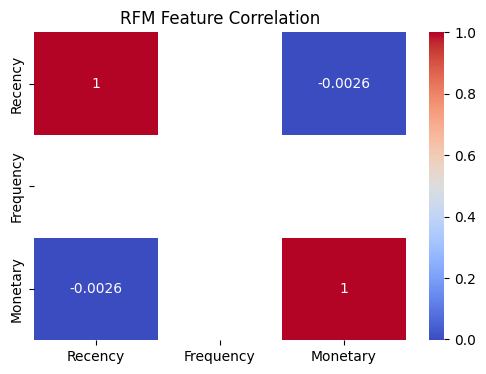

In [13]:
plt.figure(figsize=(6,4))
sns.heatmap(rfm[['Recency', 'Frequency', 'Monetary']].corr(), annot=True, cmap='coolwarm')
plt.title('RFM Feature Correlation')
plt.savefig('../images/rfm_correlation.png', dpi=300, bbox_inches='tight')
plt.show()


## 📌 Cluster Interpretation

- **Cluster 0:** High frequency & monetary, low recency → Likely Loyal Customers  
- **Cluster 1:** High recency, low frequency & monetary → At Risk or Churned  
- **Cluster 2:** Low spenders, occasional buyers  
- **Cluster 3:** New customers  

These segments can help businesses target their marketing more effectively.


In [16]:
rfm.to_csv('../data/rfm_clustered.csv', index=False)
